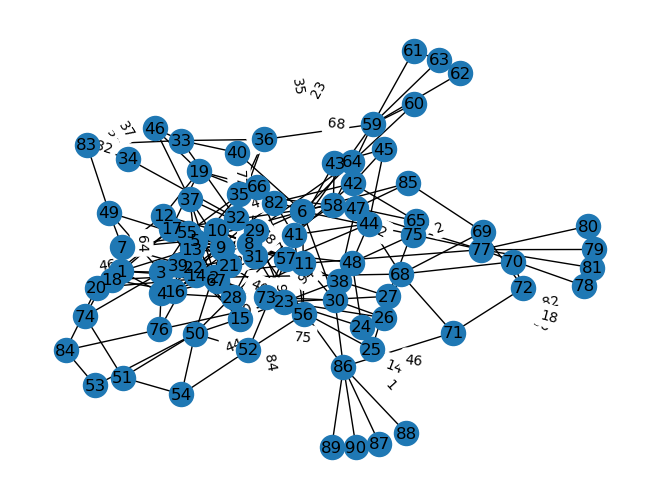

In [1]:
import pandas as pd
import networkx as nx
import random
from faker import Faker
from itertools import combinations
import matplotlib.pyplot as plt

# initial parameters
days = 10
people_per_day = 5

edge_per_node = 3

fake = Faker()

# create empty dataframes
df_customers = pd.DataFrame(columns=["FirstName", "LastName", "City", "JoinDate"])
df_accounts = pd.DataFrame(columns=["CustID", "AccountNum", "Balance", "CreatedDate"])
df_relationships = pd.DataFrame(columns=["CustID1", "CustID2", "DateEstablished"])
df_transactions = pd.DataFrame(columns=["CustID_From", "CustID_To", "AccountNum_From", "AccountNum_To", "Amount", "Date"])

G = nx.empty_graph(0)
for day in range(days):
    # Generate new customers
    for person in range(people_per_day):
        first_name = fake.first_name()
        last_name = fake.last_name()
        city = fake.city()
        df_customers.loc[len(G.nodes) + 1] = [first_name, last_name, city, day]
        
        # Add the new node to the graph
        G.add_node(len(G.nodes) + 1)
        existing_nodes = list(G.nodes)[:-1]
        max_edges = min(edge_per_node, len(existing_nodes))
        new_edges = random.sample(existing_nodes, max_edges)
        for new_edge in new_edges:
            G.add_edge(len(G.nodes), new_edge)

    # Generate relationships
    new_edges = nx.barabasi_albert_graph(people_per_day, edge_per_node).edges()
    normalized_edges = [(i + len(G.nodes), j + len(G.nodes)) for i,j in new_edges]
    G.add_edges_from(normalized_edges)
    relationships = list(combinations(range(len(G.nodes) - people_per_day, len(G.nodes)), 2))
    for rel in relationships:
        df_relationships.loc[len(df_relationships)] = [rel[0], rel[1], day]

    # Generate accounts for new customers
    for i in range(len(G.nodes) - people_per_day, len(G.nodes)):
        df_accounts.loc[len(df_accounts)] = [i, fake.random_int(min=10**9, max=10**10), fake.random_int(), day]

    # Generate transactions
    for edge in normalized_edges:
        cust1_accounts = df_accounts[df_accounts["CustID"] == edge[0]]["AccountNum"].tolist()
        cust2_accounts = df_accounts[df_accounts["CustID"] == edge[1]]["AccountNum"].tolist()
        if len(cust1_accounts) > 0 and len(cust2_accounts) > 0:
            df_transactions.loc[len(df_transactions)] = [
                edge[0], edge[1], 
                random.choice(cust1_accounts), random.choice(cust2_accounts), 
                fake.random_int(min=1, max=100), day
                ]
# Draw graph
sum_val = {key: df_transactions[(df_transactions["CustID_From"]==key[0]) & (df_transactions["CustID_To"]==key[1])]["Amount"].sum() for key in df_relationships[["CustID1", "CustID2"]].apply(tuple, axis=1)}
edge_labels = { (u,v): sum_val[(u,v)] for u,v in G.edges if (u,v) in sum_val}

nx.draw(G, with_labels = True)
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels = edge_labels)
plt.show()